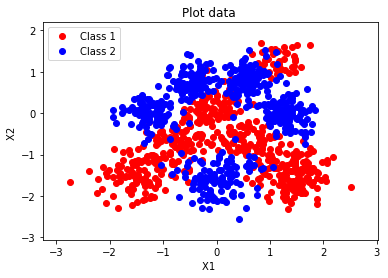

In [1]:
import numpy as np
from DataPlot import *
%matplotlib inline

X = np.loadtxt('X.txt')
y = np.loadtxt('y.txt')

# Question c; visualize the dataset; 
plot_data(X, y)

In [2]:
# Question d; split the dataset into training and test sets
# Pre-processing data
X_pos = X[y==1]
np.random.shuffle(X_pos)
X_pos_train, X_pos_test = X_pos[:400], X_pos[400:]

X_neg = X[y==0]
np.random.shuffle(X_neg)
X_neg_train, X_neg_test = X_neg[:400], X_neg[400:]

X_train = np.concatenate((X_pos_train, X_neg_train), axis = 0)
y_train = np.concatenate((np.ones((400, 1)), np.zeros((400,1) )), axis = 0)

X_test = np.concatenate((X_pos_test, X_neg_test), axis = 0)
y_test = np.concatenate((np.ones((94, 1)), np.zeros((106,1) )), axis = 0)


In [3]:
# Question e; define functions for training

class Logistic(object):
    
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        self.X_aug = np.concatenate((np.ones((features.shape[0], 1)), features), axis=1)
    
    def sigmoid(self, weights): #also is prediction
        return 1.0 / (1.0 + np.exp(-np.dot(self.X_aug, weights)))

    def gradAscent(self, weights, learnRate):
        s = self.sigmoid(weights)
        gradient = np.dot(self.X_aug.T, np.subtract(self.labels, s))
        weights = weights + learnRate * gradient
        return weights

    def train(self, learnRate, iterations):
        weights = 1*np.ones((self.X_aug.shape[1], 1)) # initial weights
        record = np.zeros((iterations, self.X_aug.shape[1]))
        for i in range(iterations):
            weights = self.gradAscent(weights, learnRate)
            record[i] = weights.T
        return weights, record

    def logLikelihood(self, record):
        ll = np.zeros(record.shape[0])
        for i in range(record.shape[0]):
            ll[i] = np.mean(self.labels * np.log(self.sigmoid(record[i].reshape(record[i].size,1))) + 
                    (1-self.labels) * np.log(1 - self.sigmoid(record[i].reshape(record[i].size,1))))
        return ll
    

logistic_train = Logistic(X_train, y_train)
weights, record = logistic_train.train(0.001, 100)

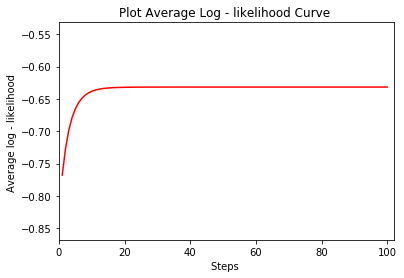

In [4]:
llTrain = logistic_train.logLikelihood(record)

plot_ll(llTrain)

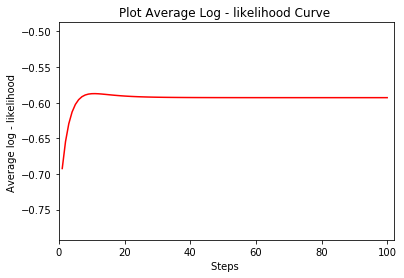

In [5]:
logistic_test = Logistic(X_test, y_test)
llTest = logistic_test.logLikelihood(record)
plot_ll(llTest)

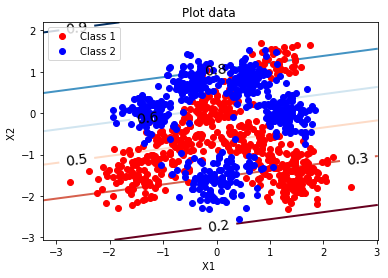

In [6]:
# a predict function
def predict(X, weights):
    X_aug = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
    return 1.0 / (1 + np.exp(-np.dot(X_aug, weights)))

plot_predictive_distribution(X, y, predict, weights)

In [7]:
#Question f 
print('final training log-likelihood is', llTrain[-1])
print('final test log-likelihood is', llTest[-1])

final training log-likelihood is -0.631652837355
final test log-likelihood is -0.592912327579


In [8]:
def confMatrix(test, label, weights, thres):
    prediction = predict(test, weights)
    prediction[prediction > thres] = 1
    prediction[prediction <= thres] = 0
    conf = np.zeros((2,2))
    conf[0, 0] = 1 - np.count_nonzero(prediction[label== 0]) / prediction[label== 0].size
    conf[0, 1] = np.count_nonzero(prediction[label== 0]) / prediction[label== 0].size
    conf[1, 0] = 1 - np.count_nonzero(prediction[label== 1]) / prediction[label== 1].size
    conf[1, 1] = np.count_nonzero(prediction[label== 1]) / prediction[label== 1].size
    return conf

print(confMatrix(X_test, y_test, weights, 0.5))

[[ 0.73584906  0.26415094]
 [ 0.25531915  0.74468085]]


In [9]:
# Question g: ROC curve
import matplotlib.pyplot as plt

def auc(x, y):
    dx = np.diff(x)
    if np.any(dx<0): 
        # reorder the data point according to the x axis
        order = np.lexsort((y,x))
        x, y = x[order], y[order]
    area = np.trapz(y, x)
    return area
    


def plot_ROC(test, label, weights):
    roc = np.zeros((1000,2))
    thres = np.linspace(1, 0, 1000)
    for i in range(1000):
        conf = confMatrix(test, label, weights, thres[i])
        roc[i, 0] = conf[0, 1]
        roc[i, 1] = conf[1, 1]
    plt.figure()
    ax = plt.gca()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    ax.plot(roc[:, 0], roc[:, 1], 'r-', label='ROC curve (area = %0.2f)'% auc(roc[:, 0], roc[:, 1]))
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operator Characteristic(ROC)')
    plt.legend(loc='lower right')
    plt.show

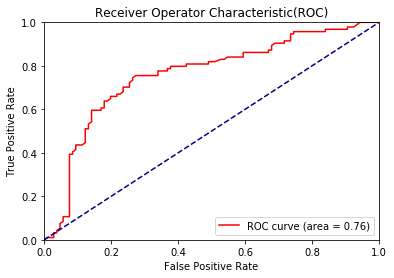

In [10]:
plot_ROC(X_test, y_test, weights)

In [11]:
# Question h; RBFs

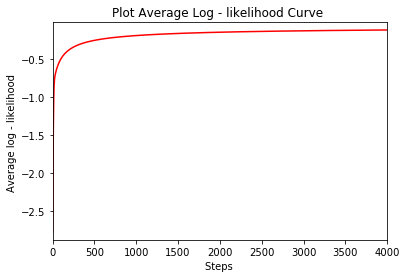

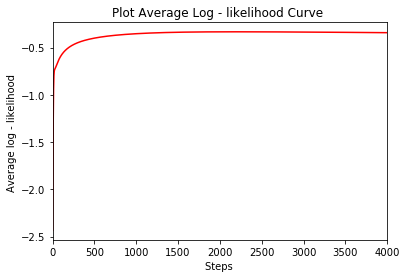

[[ 0.91509434  0.08490566]
 [ 0.19148936  0.80851064]]


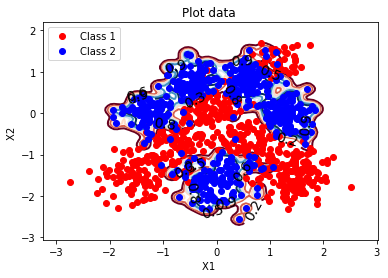

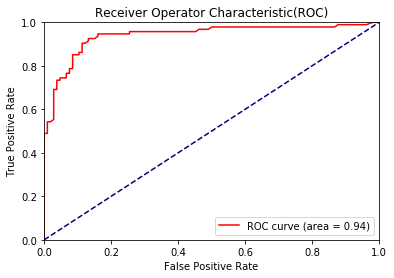

In [14]:
X_RBF_train = expand_inputs(0.1, X_train, X_train)
X_RBF_test = expand_inputs(0.1, X_test, X_train)

lo_RBF_train = Logistic(X_RBF_train, y_train)
weights, record = lo_RBF_train.train(0.001, 4000)

ll_RBF_train = lo_RBF_train.logLikelihood(record)
plot_ll(ll_RBF_train)

lo_RBF_test = Logistic(X_RBF_test, y_test)
ll_RBF_test = lo_RBF_test.logLikelihood(record)
plot_ll(ll_RBF_test)

print(confMatrix(X_RBF_test, y_test, weights, 0.5))

plot_predictive_distribution_expand(X, y, predict, expand_inputs, 0.1, X_train, weights)
plot_ROC(X_RBF_test, y_test, weights)